# Build QP Sum Template From Clean Traces

This notebook reads **all clean QP-sum traces** from:
- `/ceph/dwong/trigger_samples/PCA_QP/main`
- files matching `NR_traces_energy_*_pair_qp_sum_batch_*.h5`

Pipeline per trace:
1. Baseline subtraction using first 4000 samples.
2. Normalization by peak absolute value (post-trigger region by default).
3. Average across all normalized clean traces to make template.
4. Optional smoothing (Savitzky-Golay or moving average).

Outputs:
- Raw template (`.npy`)
- Smoothed template (`.npy`)
- Per-energy templates (`.npy`)
- Metadata (`.json`)
- Optional copy to `PCA_dev/reusable/QP_template.npy`


In [8]:
import re
import json
from pathlib import Path

import h5py
import numpy as np
import matplotlib.pyplot as plt

# Repo root resolver (works from DELight_mtr / PCA_dev / wk4)
def _repo_root():
    here = Path.cwd().resolve()
    cands = [here, here.parent, here.parent.parent]
    for c in cands:
        if (c / 'wk4').exists() and (c / 'reusable').exists():
            return c
        if (c / 'PCA_dev' / 'wk4').exists() and (c / 'PCA_dev' / 'reusable').exists():
            return c / 'PCA_dev'
    raise RuntimeError('Run from DELight_mtr, PCA_dev, or PCA_dev/wk4/make_template')

repo = _repo_root()
print('repo =', repo)

DATA_DIR = Path('/ceph/dwong/trigger_samples/PCA_QP/main')
FILE_GLOB = 'NR_traces_energy_*_pair_qp_sum_batch_*.h5'
PRETRIGGER = 2000
POSTTRIGGER_START = PRETRIGGER
NORMALIZE_POSTTRIGGER_ONLY = True
EPS = 1e-12

# Use None for all files, or set e.g. 3 for a quick smoke run.
N_FILES_MAX = None

SMOOTH_METHOD = 'savgol'   # one of: 'none', 'moving_average', 'savgol'
MOVING_AVG_WINDOW = 101
SAVGOL_WINDOW = 101
SAVGOL_POLYORDER = 3

SAVE_TO_LOCAL = True
SAVE_TO_REUSABLE = True
OUT_DIR = repo / 'wk4' / 'make_template' / 'outputs'
OUT_DIR.mkdir(parents=True, exist_ok=True)
REUSABLE_TEMPLATE_PATH = repo / 'reusable' / 'QP_template.npy'

print('data dir =', DATA_DIR)
print('output dir =', OUT_DIR)
print('reusable template path =', REUSABLE_TEMPLATE_PATH)


repo = /home/dwong/DELight_mtr/PCA_dev
data dir = /ceph/dwong/trigger_samples/PCA_QP/main
output dir = /home/dwong/DELight_mtr/PCA_dev/wk4/make_template/outputs
reusable template path = /home/dwong/DELight_mtr/PCA_dev/reusable/QP_template.npy


In [9]:
def _batch_id(path: Path) -> int:
    m = re.search(r'_batch_(\d+)', path.name)
    return int(m.group(1)) if m else -1


def _energy_ev(path: Path):
    m = re.search(r'_energy_(\d+)_', path.name)
    return int(m.group(1)) if m else None


def _to_2d_clean_sum(arr):
    arr = np.asarray(arr)
    if arr.ndim == 3:
        if arr.shape[1] == 1:
            return arr[:, 0, :]
        # fallback: if accidental multi-channel input, sum across channel axis
        return np.sum(arr, axis=1)
    if arr.ndim == 2:
        return arr
    raise ValueError(f'Unexpected traces_clean shape: {arr.shape}')


def _smooth_template(x):
    x = np.asarray(x, dtype=np.float64)
    method = SMOOTH_METHOD.lower()
    if method == 'none':
        return x.copy()

    if method == 'moving_average':
        w = int(MOVING_AVG_WINDOW)
        if w < 3:
            return x.copy()
        if w % 2 == 0:
            w += 1
        kernel = np.ones(w, dtype=np.float64) / float(w)
        return np.convolve(x, kernel, mode='same')

    if method == 'savgol':
        try:
            from scipy.signal import savgol_filter
        except Exception:
            print('scipy not available, fallback to moving_average')
            old = globals()['SMOOTH_METHOD']
            globals()['SMOOTH_METHOD'] = 'moving_average'
            y = _smooth_template(x)
            globals()['SMOOTH_METHOD'] = old
            return y

        w = int(SAVGOL_WINDOW)
        if w < 5:
            return x.copy()
        if w % 2 == 0:
            w += 1
        if w >= x.size:
            w = x.size - 1 if x.size % 2 == 0 else x.size
        p = int(SAVGOL_POLYORDER)
        p = min(max(1, p), w - 2)
        return savgol_filter(x, window_length=w, polyorder=p)

    raise ValueError(f'Unknown SMOOTH_METHOD: {SMOOTH_METHOD}')


def _init_acc(n_samples):
    return {
        'sum': np.zeros(n_samples, dtype=np.float64),
        'sum_sq': np.zeros(n_samples, dtype=np.float64),
        'count': 0,
        'n_skipped_zero_peak': 0,
    }


def _update_acc(acc, X_norm):
    if X_norm.size == 0:
        return
    acc['sum'] += np.sum(X_norm, axis=0)
    acc['sum_sq'] += np.sum(X_norm * X_norm, axis=0)
    acc['count'] += int(X_norm.shape[0])


In [10]:
files = sorted(DATA_DIR.glob(FILE_GLOB), key=_batch_id)
if N_FILES_MAX is not None:
    files = files[:int(N_FILES_MAX)]

if not files:
    raise FileNotFoundError(f'No files found: {DATA_DIR}/{FILE_GLOB}')

print('n_files =', len(files))
print('first file =', files[0].name)
print('last file  =', files[-1].name)

# infer n_samples from first file
with h5py.File(files[0], 'r') as f:
    x0 = _to_2d_clean_sum(f['traces_clean'][:])
n_samples = x0.shape[1]
print('n_samples =', n_samples)

acc_global = _init_acc(n_samples)
acc_by_energy = {}

for i, p in enumerate(files, 1):
    with h5py.File(p, 'r') as f:
        X = _to_2d_clean_sum(f['traces_clean'][:]).astype(np.float64)

    # baseline subtraction (first PRETRIGGER samples)
    baseline = np.mean(X[:, :PRETRIGGER], axis=1, keepdims=True)
    X0 = X - baseline

    # normalization by per-trace peak abs
    if NORMALIZE_POSTTRIGGER_ONLY:
        ref = X0[:, POSTTRIGGER_START:]
    else:
        ref = X0
    peak = np.max(np.abs(ref), axis=1)
    keep = peak > EPS

    Xn = X0[keep] / peak[keep, None]
    n_skip = int((~keep).sum())

    _update_acc(acc_global, Xn)
    acc_global['n_skipped_zero_peak'] += n_skip

    e = _energy_ev(p)
    if e not in acc_by_energy:
        acc_by_energy[e] = _init_acc(n_samples)
    _update_acc(acc_by_energy[e], Xn)
    acc_by_energy[e]['n_skipped_zero_peak'] += n_skip

    if i % 10 == 0 or i == len(files):
        print(f'processed {i}/{len(files)} files | global traces={acc_global["count"]}')

if acc_global['count'] == 0:
    raise RuntimeError('No valid traces after normalization.')

# build templates
template_raw = acc_global['sum'] / acc_global['count']
var = np.maximum(acc_global['sum_sq'] / acc_global['count'] - template_raw**2, 0.0)
template_std = np.sqrt(var)

# normalize template to max abs = 1
mx = np.max(np.abs(template_raw))
if mx > EPS:
    template_raw = template_raw / mx

# smoothed template
template_smooth = _smooth_template(template_raw)
mxs = np.max(np.abs(template_smooth))
if mxs > EPS:
    template_smooth = template_smooth / mxs

print()
print('Global summary:')
print('  traces used            =', acc_global['count'])
print('  skipped zero-peak      =', acc_global['n_skipped_zero_peak'])
print('  raw peak               =', float(np.max(template_raw)))
print('  smooth peak            =', float(np.max(template_smooth)))
print('  smoothing method       =', SMOOTH_METHOD)

energy_counts = {k: v['count'] for k, v in sorted(acc_by_energy.items(), key=lambda kv: (kv[0] is None, kv[0]))}
print('  traces by energy       =', energy_counts)


n_files = 20
first file = NR_traces_energy_500_pair_qp_sum_batch_0000.h5
last file  = NR_traces_energy_500_pair_qp_sum_batch_0019.h5
n_samples = 32768
processed 10/20 files | global traces=1000
processed 20/20 files | global traces=2000

Global summary:
  traces used            = 2000
  skipped zero-peak      = 0
  raw peak               = 1.0
  smooth peak            = 1.0
  smoothing method       = savgol
  traces by energy       = {500: 2000}


In [11]:
# Per-energy templates (also normalized to max abs = 1)
templates_by_energy = {}
for e, acc in sorted(acc_by_energy.items(), key=lambda kv: (kv[0] is None, kv[0])):
    if acc['count'] == 0:
        continue
    t = acc['sum'] / acc['count']
    m = np.max(np.abs(t))
    if m > EPS:
        t = t / m
    templates_by_energy[e] = t

print('per-energy templates:', {k: v.shape for k, v in templates_by_energy.items()})


per-energy templates: {500: (32768,)}


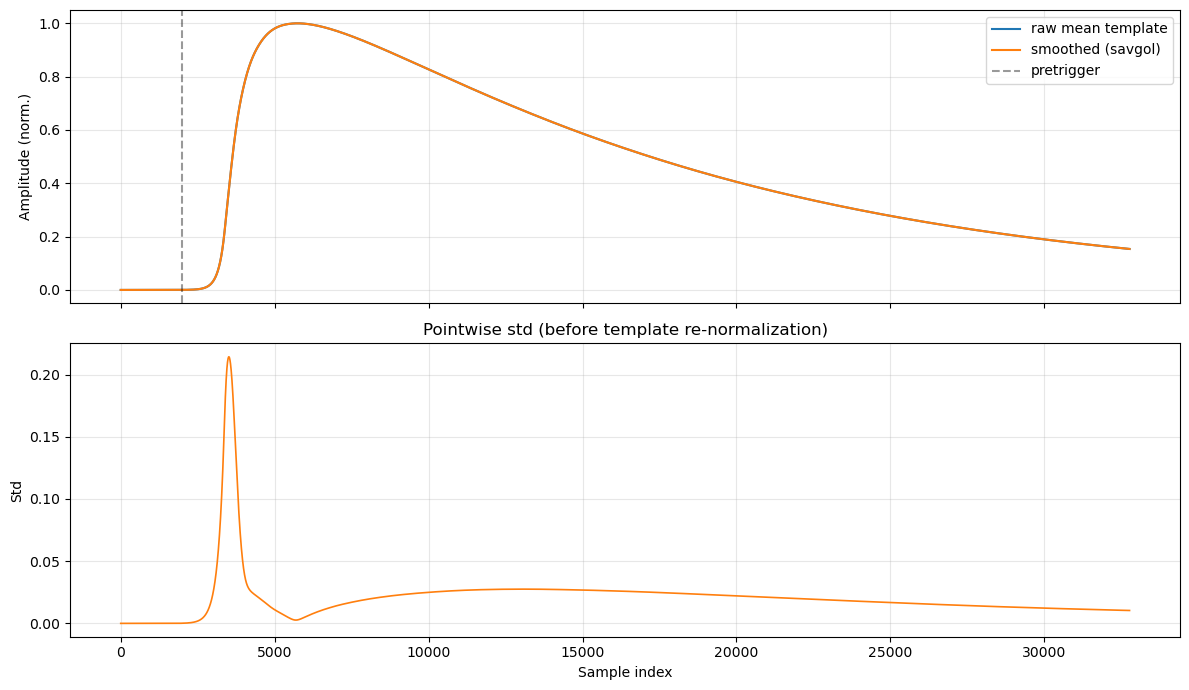

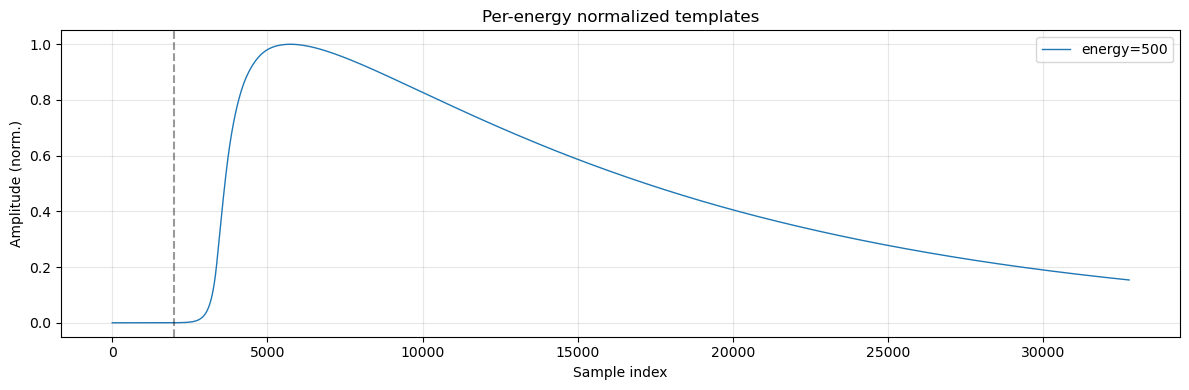

In [12]:
# Quick plots
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
axes[0].plot(template_raw, label='raw mean template', lw=1.5)
axes[0].plot(template_smooth, label=f'smoothed ({SMOOTH_METHOD})', lw=1.5)
axes[0].axvline(PRETRIGGER, color='k', ls='--', alpha=0.4, label='pretrigger')
axes[0].set_ylabel('Amplitude (norm.)')
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(template_std, color='tab:orange', lw=1.2)
axes[1].set_title('Pointwise std (before template re-normalization)')
axes[1].set_xlabel('Sample index')
axes[1].set_ylabel('Std')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

if templates_by_energy:
    plt.figure(figsize=(12, 4))
    for e, t in templates_by_energy.items():
        plt.plot(t, lw=1.0, label=f'energy={e}')
    plt.axvline(PRETRIGGER, color='k', ls='--', alpha=0.4)
    plt.title('Per-energy normalized templates')
    plt.xlabel('Sample index')
    plt.ylabel('Amplitude (norm.)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [13]:
# Save outputs
saved = {}
if SAVE_TO_LOCAL:
    raw_path = OUT_DIR / 'QP_template_raw.npy'
    smooth_path = OUT_DIR / 'QP_template_smooth.npy'
    std_path = OUT_DIR / 'QP_template_std.npy'

    np.save(raw_path, template_raw)
    np.save(smooth_path, template_smooth)
    np.save(std_path, template_std)

    saved['raw'] = str(raw_path)
    saved['smooth'] = str(smooth_path)
    saved['std'] = str(std_path)

    # Save per-energy templates
    energy_paths = {}
    for e, t in templates_by_energy.items():
        p = OUT_DIR / f'QP_template_energy_{e}.npy'
        np.save(p, t)
        energy_paths[str(e)] = str(p)
    saved['per_energy'] = energy_paths

if SAVE_TO_REUSABLE:
    REUSABLE_TEMPLATE_PATH.parent.mkdir(parents=True, exist_ok=True)
    np.save(REUSABLE_TEMPLATE_PATH, template_smooth)
    saved['reusable_qp_template'] = str(REUSABLE_TEMPLATE_PATH)

meta = {
    'data_dir': str(DATA_DIR),
    'file_glob': FILE_GLOB,
    'n_files': len(files),
    'pretrigger': PRETRIGGER,
    'posttrigger_start': POSTTRIGGER_START,
    'normalize_posttrigger_only': NORMALIZE_POSTTRIGGER_ONLY,
    'eps': EPS,
    'n_traces_used': int(acc_global['count']),
    'n_skipped_zero_peak': int(acc_global['n_skipped_zero_peak']),
    'smooth_method': SMOOTH_METHOD,
    'moving_avg_window': MOVING_AVG_WINDOW,
    'savgol_window': SAVGOL_WINDOW,
    'savgol_polyorder': SAVGOL_POLYORDER,
    'traces_by_energy': {str(k): int(v['count']) for k, v in sorted(acc_by_energy.items(), key=lambda kv: (kv[0] is None, kv[0]))},
    'saved': saved,
}

meta_path = OUT_DIR / 'QP_template_build_meta.json'
with open(meta_path, 'w') as f:
    json.dump(meta, f, indent=2)

print('saved files:')
for k, v in saved.items():
    print(f'  {k}: {v}')
print('meta:', meta_path)


saved files:
  raw: /home/dwong/DELight_mtr/PCA_dev/wk4/make_template/outputs/QP_template_raw.npy
  smooth: /home/dwong/DELight_mtr/PCA_dev/wk4/make_template/outputs/QP_template_smooth.npy
  std: /home/dwong/DELight_mtr/PCA_dev/wk4/make_template/outputs/QP_template_std.npy
  per_energy: {'500': '/home/dwong/DELight_mtr/PCA_dev/wk4/make_template/outputs/QP_template_energy_500.npy'}
  reusable_qp_template: /home/dwong/DELight_mtr/PCA_dev/reusable/QP_template.npy
meta: /home/dwong/DELight_mtr/PCA_dev/wk4/make_template/outputs/QP_template_build_meta.json


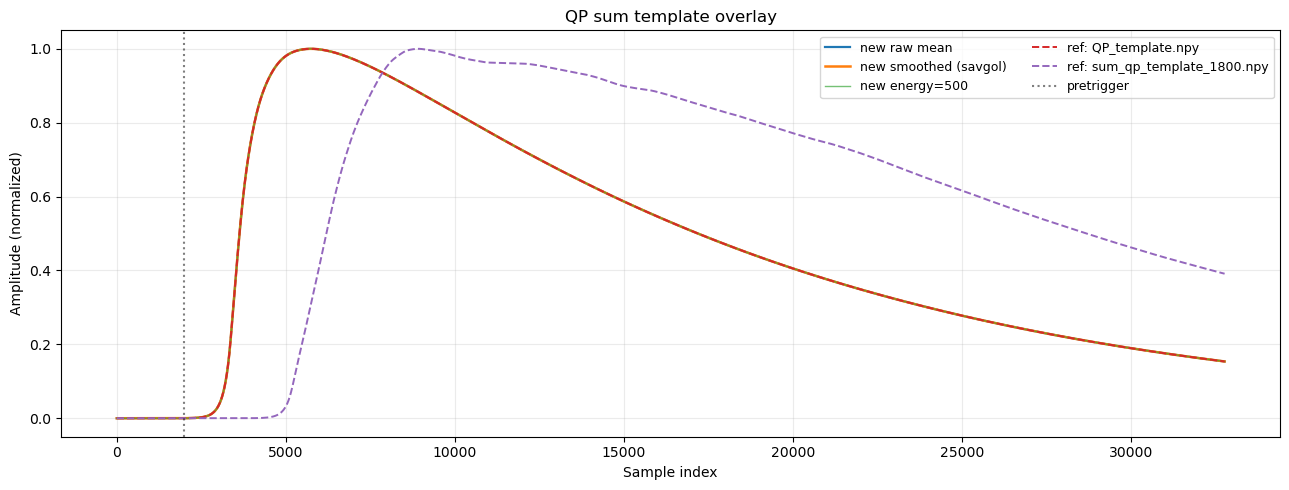

In [14]:
# Overlay plot: raw/smoothed/new templates vs existing references
plt.figure(figsize=(13, 5))

# Current build outputs
plt.plot(template_raw, lw=1.6, label='new raw mean')
plt.plot(template_smooth, lw=1.8, label=f'new smoothed ({SMOOTH_METHOD})')

# Per-energy templates from this run
for e, t in sorted(templates_by_energy.items(), key=lambda kv: (kv[0] is None, kv[0])):
    plt.plot(t, lw=1.0, alpha=0.65, label=f'new energy={e}')

# Existing template references (if found)
ref_candidates = [
    repo / 'reusable' / 'QP_template.npy',
    repo.parent / 'trigger_study' / 'archive' / 'wk9' / 'preliminary' / 'sum_qp_template_1800.npy',
]

for rp in ref_candidates:
    if rp.exists():
        r = np.load(rp).astype(np.float64).squeeze()
        if r.ndim != 1:
            continue
        m = np.max(np.abs(r))
        if m > EPS:
            r = r / m
        plt.plot(r, ls='--', lw=1.4, label=f'ref: {rp.name}')

plt.axvline(PRETRIGGER, color='k', ls=':', alpha=0.5, label='pretrigger')
plt.title('QP sum template overlay')
plt.xlabel('Sample index')
plt.ylabel('Amplitude (normalized)')
plt.grid(alpha=0.25)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()
